In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Previos

In [ ]:
!pip install pycwt

     |████████████████████████████████| 758 kB 4.1 MB/s 
  Created wheel for pycwt: filename=pycwt-0.3.0a22-py3-none-any.whl size=17824 sha256=307f6f427e159e2d5d282e00a4377d72cb445b9644128928b5fb8ac6ce7eb682
  Stored in directory: /root/.cache/pip/wheels/53/99/6b/a43c99414482c20862ca8917862237de8bd27ee795a55faa6c
Successfully built pycwt


In [ ]:
from pycwt import wavelet
import pandas as pd 
import numpy as np
import scipy.ndimage.measurements as ndi
import os 
import glob 
import datetime
from dateutil import relativedelta as rdelta
import datetime as dt
 
import matplotlib as mpl
import pylab as plt
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
path_abs = '/content/drive/Shareddrives/Hidrología Aplicada'
path_base = path_abs + '/1_Análisis de series hidrológicas/'
path_series = path_base + '1_Series/' #Estaciones con datos brutos sin algunas fechas
path_procesados = path_base + '1_Procesados/' #Con estas estaciones vamos a trabajar
path_shapes = path_base + '2_Shapes/'
path_departamentos = path_shapes + 'MGN_DPTO_POLITICO'
path_figuras = path_base + '3_Figuras/'
 
archivos = glob.glob(path_procesados + '*')
archivos.sort()
procesados = np.sort(glob.glob(path_procesados + '*'))

In [ ]:
info_estaciones = pd.read_csv(path_base + '01_Informacion_Estaciones.csv', index_col = 0)
info_estaciones.sort_index()
estaciones_analisis =  info_estaciones[info_estaciones['SiAnalizar'] == True]

# Onditas

## Funciones Onditas

In [ ]:
def Onditas_Continuas(serie, delta_time):

    x = serie
    fechas = x.index

    import pandas as pd
    import numpy as np
    import pycwt as wavelet
    from pycwt.helpers import find

    data_inicio = serie.index[0].year
    data_fin = serie.index[-1].year

    s = np.array(x)
    t = np.linspace(0, len(s)*delta_time, len(x))
    dt = np.diff(t)[0]
    n = t.size

    # Calculate the CWT of both time series. The function wavelet.cwt

    mother = wavelet.Morlet(6.)         # Morlet mother wavelet with m=6
    slevel = 0.95                       # Significance level
    dj     = 1/12.                      # Twelve sub-octaves per octaves
    s0     = 20*dt                      # Starting scale
    J      = 7/dj                       # Seven powers of two with dj sub-octaves

    if True:
        alpha, _, _ = wavelet.ar1(s)  # Lag-1 autocorrelation for red noise
    else:
        alpha = 0.0                    # Lag-1 autocorrelation for white noise

    #The following routines perform the wavelet transform and siginificance
    W, scales, freqs, coi, _, _ = wavelet.cwt(s, dt, dj, s0, J, mother)
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha, significance_level = slevel, wavelet = mother)

    power = (np.abs(W)) ** 2            # Power spectrum
    period = 1/freqs
    sig95 = np.ones([1, n]) * signif[:, None]
    sig95 = power/sig95               # Where ratio > 1, power is significant

    return power, sig95, period, coi, fechas

#Función para graficar el espectro de onditas
def GraficaOnditas(power, period, sig95, coi, fechas, ruta_save):

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    period = period*365

    csfont = {'fontname':'serif', 'size':16,'weight' : 500}
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 16
    plt.rcParams["figure.titleweight"] = 'normal'

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1, 1, 1)

    a = np.min(power)
    b = np.nanmean(power[:np.where(period>=160)[0][0]])*3.5
    bounds = np.arange(a, b, (b-a)/100.)

    plt.contourf(fechas, period, power, len(bounds), cmap = plt.cm.jet, levels = bounds, extend = 'max')
    plt.colorbar(format ='%1.f').set_label(u'Potencia', **csfont)

    plt.xlim(fechas[0], fechas[-1])
    plt.ylim([np.min(period), np.max(period)])
    plt.xticks(rotation=90)
    plt.ylabel(u'Frecuencia (días)', **csfont)
    ax.set_yscale('log', basey=2, subsy=None)

    yticks=[[30,60,90,180,365,1460], [30,60,90,180,365,1460]]
    plt.yticks(yticks[0], yticks[1])

    axx = plt.gca().yaxis
    axx.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    ax.invert_yaxis()

    plt.contour(fechas, period, sig95, [1, 99], colors='k')

    delta = fechas[1] - fechas[0]
    plt.fill(np.concatenate([fechas, fechas[-1:]+delta, fechas[-1:]+delta, fechas[:1]-delta, fechas[:1]-delta]), 
             np.concatenate([coi*365, [1e-9], period[-1:], period[-1:], [1e-9]]),
             'w', alpha=0.6, hatch='x', edgecolor='dimgray')
    plt.savefig(ruta_save, bbox_inches='tight', dpi = 200)
    plt.close()



year = 5
def resample_func(values):
    if np.isnan(values).all():
        return np.nan
    else:
        return np.mean(values)


def standardize(data, pandas_stat):   #'dayofyear'
    # noinspection PyBroadException
    try:
        data_nan = data.loc[pd.isnull(data).any(1), :]
        data = data.dropna()

    except:
        pass

    # groups = data.groupby(by=data.index.dayofyear)
    groups = data.groupby(by=getattr(data.index, pandas_stat))

    data_mean = np.zeros(len(groups))
    data_std = np.zeros(len(groups))

    for date_element, group in groups:
        mean = group.mean(skipna=True)
        std = group.std(skipna=True)

        data_mean[date_element - 1] = mean
        data_std[date_element - 1] = std

        anomalies_temp = (group - mean)
        anomalies_std_temp = anomalies_temp / std

        if date_element == 1:
            anomalies = anomalies_temp
            anomalies_std = anomalies_std_temp
        else:
            anomalies = pd.concat([anomalies, anomalies_temp])
            anomalies_std = pd.concat([anomalies_std, anomalies_std_temp])

    # noinspection PyBroadException
    try:
        anomalies = pd.concat([anomalies, data_nan])
        anomalies_std = pd.concat([anomalies_std, data_nan])

    except:
        pass

    anomalies = pd.DataFrame(anomalies.sort_index())
    anomalies_std = pd.DataFrame(anomalies_std.sort_index())

    return anomalies, anomalies_std, data_mean, data_std

## Series

## Análisis Onditas

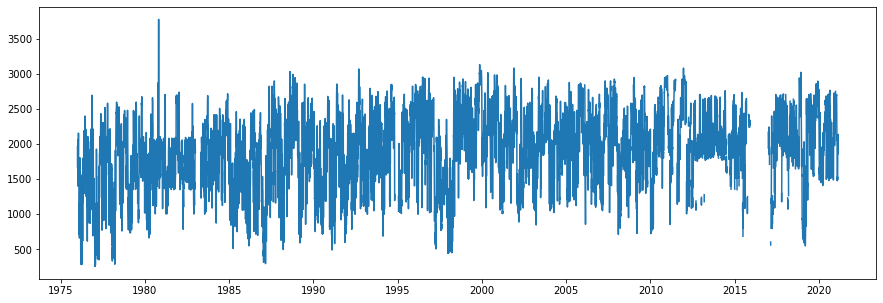

In [ ]:
plt.figure(figsize=[15, 5])
plt.plot(data)

In [ ]:
df_raw = data
clim = serie_mean
limit = 10
variable = 'Q'
def completa_climatologia(df_raw, clim, limit, variable='Q'):
    df = df_raw.copy()
    valid_rows = df.isnull().any(axis=1)
    label, _ = ndi.label(valid_rows)
    groups =  df.groupby(label)

    df_clim = pd.DataFrame({'Q': clim}, columns=[variable],
                        index=pd.date_range(dt.datetime(2000, 1,1), periods=366, freq='D'))

    for aux, group in groups:
        if len(group) <= limit:
            for date in group.index:
                df.loc[date] = df_clim.loc[dt.datetime(year=2000, month=date.month, day=date.day)]

    return df

df_new = completa_climatologia(df_raw, clim, limit)

NameError: ignored

In [ ]:
completa_climatologia(serie, serie_mean, 15).isnull().sum(), serie.isnull().sum()

(Q    756
 dtype: int64, Q    1132
 dtype: int64)

In [ ]:
serie.isnull().sum()


Q    838
dtype: int64

In [ ]:
serie = completa_climatologia(serie, serie_mean, limit)

In [ ]:
list1 = []
list2 = []

In [ ]:
valid_rows = ~serie.isnull().any(axis=1)
label, num_feature = ndi.label(valid_rows)
label_of_biggest_group =  valid_rows.groupby(label).count().drop(0).argmax()
print(serie.loc[label == label_of_biggest_group])

                     Q
1976-01-01   72.847810
1976-01-02   -4.168800
1976-01-03  -47.051016
1976-01-04 -153.497967
1976-01-05  -39.572917
...                ...
1982-12-27   61.917113
1982-12-28   22.306270
1982-12-29    0.583333
1982-12-30  -41.985518
1982-12-31  -74.433783

[2557 rows x 1 columns]


In [ ]:
nombre_estacion

'SAN ANTONIO PADUA  - AUT [11057020]'

In [ ]:
for aux, codigo in enumerate(estaciones_analisis.index):
    data = pd.read_csv(path_procesados + str(codigo) + '.csv', index_col = 0, parse_dates = True)   
    nombre_estacion = info_estaciones.loc[codigo, 'NombreEstacion']
    data['Q'][data['Q']<0] = np.nan
  
    serie = data['Q']
    _, serie_anom, serie_mean, serie_std = standardize(data['Q'], 'dayofyear')
    # serie = completa_climatologia(serie, serie_mean, 10)

    pos_nan = list(np.where(np.isnan(serie_anom)==True)[0])

    if pos_nan!=[]:
        pos_nan.insert(0, 0)
        dif = serie_anom.index[pos_nan][1:]-serie_anom.index[pos_nan][:-1]
        ini = pos_nan[np.where(dif==max(dif))[0][0]]
        fin = pos_nan[np.where(dif==max(dif))[0][0] + 1]
        serie_anom = serie_anom[ini+1:fin]
        serie = serie[serie_anom.index[0]:serie_anom.index[-1]]
    else:
        serie = serie[serie_anom.index[0]:serie_anom.index[-1]]
        
        serie_anom = pd.Series(serie_anom, index=serie_anom.index)
        serie = pd.Series(serie, index=serie.index)
    
    print(len(serie), round(len(serie)/365, 0), nombre_estacion)
    list2.append(len(serie))

    break
    
    # if len(serie_anom)>365*year:
        
    #     delta_time = 1/365
    #     power, sig95, period, coi, fechas = Onditas_Continuas(serie, delta_time)
    #     ruta_save = '/content/drive/Shareddrives/Hidrología Aplicada/1_Análisis de series hidrológicas/3_Figuras/Onditas/Sin_anomalias/Sin_anom' + nombre_estacion + '.png'
    #     GraficaOnditas(power, period, sig95, coi, fechas, ruta_save)
    #     # power, sig95, period, coi, fechas = Onditas_Continuas(serie_anom, delta_time)
    #     # ruta_save = '/content/drive/Shareddrives/Hidrología Aplicada/1_Análisis de series hidrológicas/3_Figuras/Onditas/Anomalias/Anom' + nombre_estacion + '.png'
    #     # GraficaOnditas(power, period, sig95, coi, fechas, ruta_save)
    # else:
    #     pass



4202 12.0 SAN ANTONIO PADUA  - AUT [11057020]


In [ ]:
for i, j in zip(list1, list2):
    print(i, j, i-j)

In [ ]:
serie

1983-05-01    1713.0
1983-05-02    1434.0
1983-05-03    1230.0
1983-05-04    1238.0
1983-05-05    1475.0
               ...  
1994-10-27    1401.0
1994-10-28    1195.0
1994-10-29    1235.0
1994-10-30    1343.0
1994-10-31    1280.0
Name: Q, Length: 4202, dtype: float64